# Dendritic Disnihibition

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

## Rate Pyramidal Model

VIP neurons suppress SOM neurons and disinhibt pyramidal dendrites. The rate model approximates the spiking model with rates.

Alignment of excitation and disinhibition can allow pathway-specific gating.

The time averaged voltage of a dendritic compartment is a sigmoidal function of total excitatory input conductance ($g_E$).

$$ \bar{V_D} = f_V(\bar{g_E}, \bar{g_I}) = 30 \times \left[1 + \tanh\left(\frac{\bar{g_E} - g_{1/2}}{\beta}\right)\right] + V_0 + E_L $$

$\bar{g_E}$ and $\bar{g_I}$ are the time-averaged total conductance of all excitatory and inhibitory synapses.
$g_{1/2}$ is the midpoint proportional to the total inihibitory conductance $g_I$.

$\bar{g_I}$ is given by
$$ \bar{g_I} = r_I \tau_\mathrm{GABA} \tilde{g}_\mathrm{GABA}$$

$\bar{g_E}$ is given by
$$ \bar{g_E} = N_\mathrm{NMDA} \bar{s}_\mathrm{NMDA} \tilde{g}_\mathrm{NMDA} $$ 
where $N_\mathrm{NMDA}$ is the number of synapses for NMDAR-only excitatory input, $\bar{s}_\mathrm{NMDA}$ is the approximate time-averaged gating variable of a single synapse, and $\tilde{g_\mathrm{NMDA}}$ is the maximal conductance of the synapse. The excitatory conductance saturates as the gating variable does.

The gating variable is given by

$$ \bar{s}_\mathrm{NMDA} = 1 - (1 + r_E \tau_\mathrm{NMDA, rise} \tau_\mathrm{NMDA, decay} \alpha_\mathrm{NMDA})^{-1}$$

The rate is a function of the sum of input current from dendrites and the somatic inhibition from PV neurons if applicable.
$$ I = G_C \cdot (\langle V_D \rangle - E_\mathrm{reset})$$

$$ r = [\max(0, I + 174.76)/45.16]^{2.89}$$

Somatic voltage fluctuates around $E_\mathrm{reset}$ and there is a mean dendritic voltage $V_D$.

In [3]:
def default_params(**kwargs):
    p = {}
    
    ### Dendritic voltage function ###
    p['b_g'] = 5.56
    p['k'] = 9.64 #[nS]
    p['gamma'] = 6.54 #[nsiemens]
    p['V_0'] = 0.78 #[mv]
    p['Ereset'] = -50. #[mV]
    
    ### Dendrite to Soma ###
    p['Gc'] = 8 # Total dendrite-soma coupling of all dendrites. [nS] = [A/V 1e-9] 
    p['gLD'] = 4. # Leak conductance [nS]
    p['N_NMDA'] = 15 # unitless number of NMDA synapses
    p['g_NMDA'] = 2.5 #[nS] maximum NMDA synaptic conductance
    p['tau_NMDA_rise'] = 2e-3 #[s]
    p['tau_NMDA_decay'] = 100e-3 #[s]
    p['alpha_NMDA'] = 0.3e3 #[1/s]
    p['tau_GABA'] = 20e-3 #[s] GABA gating variable time constant
    p['g_GABA'] = 4.0 #[nsiemens] maximum GABA synaptic conductance
     
    ### connection strengths ###
    p['Jvip-som'] = -0.5 #[nA]
    p['Jpyr-vip'] = 0.5 #[nA]
    p['Jpv-pv'] = 0.5 #[nA]
    p['Jpv-pyr'] = -0.5 #[nA]
    p['Jpv-vip'] = 0.5 #[nA]
    
    ### synaptic parameters ###
    p['tau_PV'] = 2e-3 #[s]
    p['tS'] = 0.1      # [s] Time scale of synaptic gating


    ### Stimulus Parameters ###
    p['Ntrials'] = 5   # Total number of trials
    p['Tstim'] = 1.    # Time of stimulus 1 onset [sec]
    p['Tdur'] = 2.     # Duration of stimulus 1 [sec]
    
    ### interneuronal network ###
    p['nsom'] = 160
    p['nvip'] = 140
    p['npyr'] = 3000
    p['npv'] = 200
    
    ### simulation parameters ###
    p['T']         = 10. # Total duration of simulation [sec]
    p['dt']        = 0.1 # Simulation time step [sec]
    
    return p

In [4]:
def FI_pyr(I, a = 174.86, b = 45.16, g  = 2.89):
    '''
    return the firing rate of the soma as a function of the input current.
    a, b, g: default parameters are from fitting with simulation from ncomms paper
    '''
    return [(max(0,i + a)/b)**g for i in I] # Hz
    
def Ipyr_dend(p, rE, rI, Iext=0):
    '''
    Args
    p: parameters
    rE: excitatory rate (externally controlled stimulus) to dendrite
    rI: inhibition rate from SOM neurons
    Iext: any external current to the dendrite that isn't from SOM or stimulus
    '''
    
    IDtoS = p['Gc']*(VD(rE, rI, p) - p['Ereset'])*1e12 #[pA] = [nS]*[mV]*1e12
    
    I = IDtoS + Iext
    return I
    
def VD(rE, rI, p):
    '''
    average voltage of a pyramidal neuron
    Args
    gE, gI: excitatory and inhibitory conductance in [nS]
    '''
    # time-averaged gating variable if a single synapse receiving input rate r_E
    s_NMDA = 1 - (1 + rE*p['tau_NMDA_rise']*p['tau_NMDA_decay']*p['alpha_NMDA'])**(-1) # unitless

    gE = p['N_NMDA']*s_NMDA*p['g_NMDA'] #excitatory conductance [nS]
    gI = rI*p['tau_GABA']*p['g_GABA'] #inhibitory conductance [nS]
    
    midpoint = p['b_g']*(p['gLD'] + gI) # midpoint [nS]
    width = p['k']*np.exp(gI/p['gamma']) # [nS]

    return 30*(1 + np.tanh((gE - midpoint)/width)) + p['V_0'] - 70 #[mV]
    #return p['tau_NMDA_rise']*p['tau_NMDA_decay']*p['alpha_NMDA']

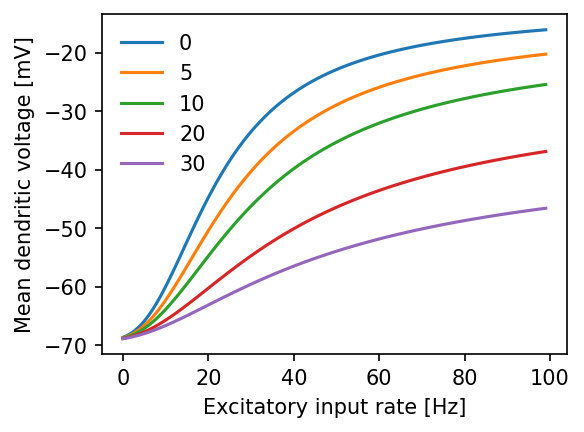

In [5]:
# sanity check: plot dendritic voltage

p = default_params()
rE = np.arange(0,100)
y = VD(rE, 1, p)

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.set(xlabel = 'Excitatory input rate [Hz]', ylabel = 'Mean dendritic voltage [mV]')
for ri in [0, 5, 10, 20, 30]:
    ax.plot(rE, VD(rE, ri, p), label = str(ri))
ax.legend(frameon=False)

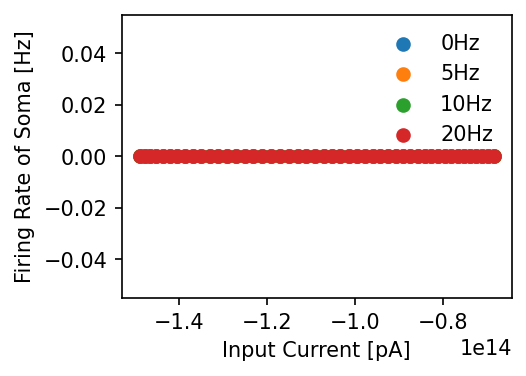

In [44]:
def plotFI():
    fig, ax = plt.subplots(figsize=(4,3), dpi=150)
    plt.subplots_adjust(left=0.25, bottom=0.25)

    params = default_params()
    
    rE = np.arange(2, 50, 1)

    # plot different rI values
    for ri in [0, 5, 10, 20]:
        inputI = Ipyr_dend(params, rE, 40, 0)
        rates = FI_pyr(inputI)

        ax.scatter(inputI, rates, label = str(ri) + 'Hz')
        ax.set(ylabel="Firing Rate of Soma [Hz]", xlabel = "Input Current [pA]")
    plt.legend(frameon = False)

plotFI()

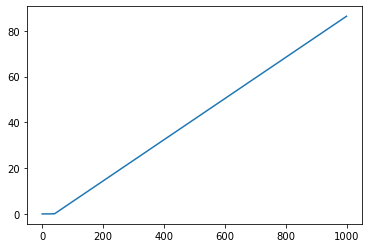

In [31]:
def FI_som(IsynSOM):
    #Firing rate of a SOM neuron: input should be in pA
    threshold = 40 #[pA]
    BetaSOM = 90 #[Hz/nA]
    
    return max(0, BetaSOM*(IsynSOM - threshold)*1e-3) #IsynSOM must be in [pA]
    
def FI_pv(IsynPV):
    # Firing rate of PV neuron.
    threshold = 40 #[pA]
    BetaPV = 220 #[Hz/nA]
    
    return max(0, BetaPV*(IsynPV - threshold)*1e-3) #IsynSOM must be in [pA]

def FI_vip(IsynVIP):
    threshold = 40 #[pA]
    return (IsynVIP > threshold)*5

x = np.linspace(0,1000)
plt.plot(x, np.array([FI_som(xi) for xi in x]))

In [32]:
class full_circuit_model:    
    def __init__(self, pars, extraParams=None):
        self.params = pars
        
        if extraParams:
            for key in extraParams:
                self.params[key] = extraParams[key]
        
    def run_sim(self, **kwargs):
        p = self.params
        
        results = {}

        t_range = np.arange(0, p['T'], p['dt'])
        nsteps = t_range.size
        
        #initialize
        s_pyr = np.zeros(nsteps)
        s_som = np.zeros(nsteps)
        s_vip = np.zeros(nsteps)
        s_pv = np.zeros(nsteps)
        
        r_pyr = np.zeros(nsteps)
        r_som = np.zeros(nsteps)
        r_vip = np.zeros(nsteps)
        r_pv = np.zeros(nsteps)
        
        Inoise_pyr = np.zeros(nsteps)
        Inoise_som = np.zeros(nsteps)
        Inoise_vip = np.zeros(nsteps)
        Inoise_pv = np.zeros(nsteps)
                
        for t in range(nsteps - 1):
            # Control Input
            Jsom_control = 0.5 #[nA]
            Jvip_control = 1-Jsom_control
            
            # Total synaptic input
            Isom = Jsom_control + Inoise_som[t]  #[nA]
            #Ivip = p['Jpyr-vip']*s_pyr[t] + p['Jpv-vip']*s_pv[t] + Inoise_vip[t] #[nA]
            Ipv = p['Jpv-pv']*s_pv[t] + Inoise_pv[t] #[nA]
            #Ipyr_som = p['Jpv-pyr']*s_pv[t] + Inoise_pyr[t] #[nA]
            Ipyr = p['Jsom-pyr']*s_som[k] + p['I0'] + p['Jaext']*p['mu0']*(1 + p['coh']/100) + Inoise_pyr[k]
            
            # Transfer functions
            r_som[t] = FI_som(Isom*1e3)
            #r_vip[t] = FI_vip(Ivip*1e3)
            r_pv[t] = FI_pv(Ipv*1e3)
            r_pyr[t] = FI_pyr(Ipyr_dend(p, 30,) + Ipyr_som*1e3)
            
            # forward euler integration for synaptic gating variables
            s_som[t+1] = s_som[t] + p['dt']*(-s_som[t]/p['tS'] + (1 - s_som[t])*p['gamma']*r_som[t])
            #s_vip[t+1] = s_vip[t] + p['dt']*(-s_vip[t]/p['tS'] + (1 - s_vip[t])*p['gamma']*r_vip[t])
            s_pv[t+1] = s_pv[t] + p['dt']*(-s_pv[t]/p['tS'] + (1 - s_pv[t])*p['gamma']*r_pv[t])
            s_pyr[t+1] = s_pyr[t] + p['dt']*(-s_pyr[t]/p['tS'] + (1 - s_pyr[t])*p['gamma']*r_pyr[t])
            
#             Inoise_pyr[t+1] = Inoise_pyr[t] + (dt/tau0) * (Ib1-Inoise_pyr[t]) + np.sqrt(dt/tau0)*sigma*gwn[t, 0]
#             Inoise_som[t+1] = Ieta2[t] + (dt/tau0) * (Ib2-Ieta2[t]) + np.sqrt(dt/tau0)*sigma*gwn[t, 1]
        
        results = {
            'trange': t_range,
            'rpyr': r_pyr,
            'rsom': r_som,
            #'rvip': r_vip,
            'rpv': r_pv
        }
        
        return results
    

<ipython-input-5-27530dca9f89>:36: RuntimeWarning: overflow encountered in exp
  width = p['k']*np.exp(gI/p['gamma']) # [nS]
<ipython-input-32-db1f4ae77787>:55: RuntimeWarning: overflow encountered in double_scalars
  s_pyr[t+1] = s_pyr[t] + p['dt']*(-s_pyr[t]/p['tS'] + (1 - s_pyr[t])*p['gamma']*r_pyr[t])
<ipython-input-32-db1f4ae77787>:55: RuntimeWarning: invalid value encountered in double_scalars
  s_pyr[t+1] = s_pyr[t] + p['dt']*(-s_pyr[t]/p['tS'] + (1 - s_pyr[t])*p['gamma']*r_pyr[t])


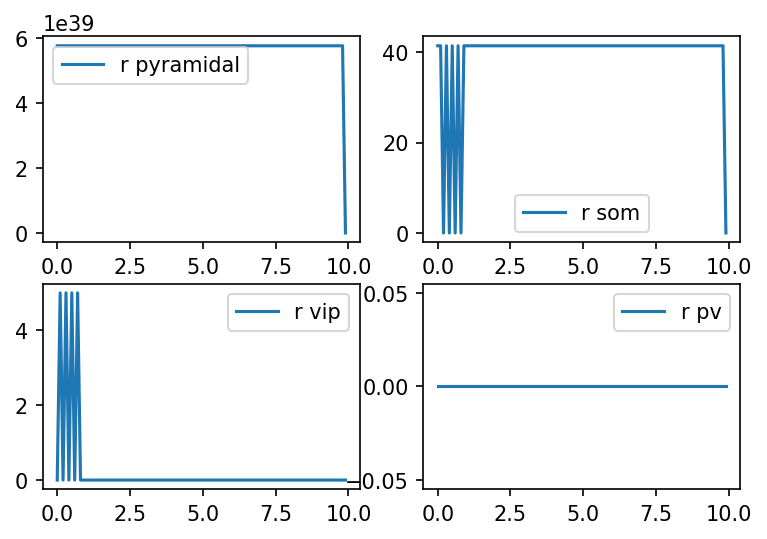

In [33]:
# plot the rate as a function of time

sim = full_circuit_model(default_params())
res = sim.run_sim()

fig, axs  = plt.subplots(2,2,  dpi=150)
axs[0][0].plot(res['trange'], res['rpyr'], label = 'r pyramidal')
axs[0][0].legend()

axs[0][1].plot(res['trange'], res['rsom'], label = 'r som')
axs[0][1].legend()

axs[1][0].plot(res['trange'], res['rvip'], label = 'r vip')
axs[1][0].legend()

axs[1][1].plot(res['trange'], res['rpv'], label = 'r pv')
axs[1][1].legend()

